In [4]:
import os
import random
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

from libs.utils import *
from libs.generate_boxes import *

In [5]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
tf.get_logger().setLevel('INFO')
tf.keras.backend.floatx()

'float32'

In [6]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20,10)

In [7]:
def build_actor(state_size, action_size):
    actor = Sequential(name='actor')
    actor.add(Dense(24, input_dim = state_size, activation='relu'))
    
    if action_size == 1:
        actor.add(Dense(action_size, activation='linear'))
    else:
        actor.add(Dense(action_size, activation='softmax'))
    actor.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001))
    return actor

In [8]:
def build_critic(state_size):
    critic = Sequential(name='critic')
    critic.add(Dense(24, input_dim = state_size, activation='relu'))
    critic.add(Dense(1, activation='linear'))
    critic.compile(loss='mse', optimizer=Adam(lr=0.005))
    return critic

In [9]:
class Bpp3DEnv():
    def __init__(self,length=20, breadth=20, height=20):
        super(Bpp3DEnv, self).__init__()
        self.length=length
        self.breadth=breadth
        self.height=height
        self.container=np.zeros((self.length,self.breadth))
    
    def step(self, upleft,bxl,bxb,bxh):
        self.container[upleft[0]:upleft[0]+bxl,upleft[1]:upleft[1]+bxb] += bxh
        return self.container, self.terminal_reward()
    
    def reset(self):
        self.container=np.zeros((self.length,self.breadth))
    
    def terminal_reward(self):
        return np.sum(self.container)/(self.length*self.breadth*self.height)

In [66]:
env = Bpp3DEnv()
N_MDD = 50
env.reset()
boxes, gt_pos = generation_3dbox(case_size=[[20,20,20]],min_s=1,N_mdd=N_MDD,is_prediv='2h')
state_size = 20*20
action_size = 4
actor = build_actor(state_size, action_size)
critic = build_critic(state_size)

In [67]:
box_list, pos_list = [], []

In [68]:
history = env.container.copy()
boxes = boxes[0]
gt_pos = gt_pos[0]
boxes

array([[ 5,  5,  3],
       [ 5, 20,  3],
       [ 5,  5,  3],
       [ 5,  5,  3],
       [ 5,  5,  3],
       [ 5,  5,  3],
       [ 5,  5,  3],
       [ 5, 10,  3],
       [ 5,  5,  3],
       [ 5,  5,  3],
       [ 5,  5,  6],
       [ 5,  5,  3],
       [ 5,  4,  3],
       [ 5,  4,  3],
       [10,  4,  3],
       [ 5,  4,  3],
       [10,  4,  3],
       [ 5,  4,  3],
       [ 5,  5,  3],
       [ 5,  4,  3],
       [ 5,  4,  3],
       [ 5, 20,  3],
       [ 5,  5,  3],
       [ 5,  5,  3],
       [ 5,  5,  7],
       [ 5, 10,  7],
       [ 5, 10,  7],
       [ 5,  5,  7],
       [ 5,  5,  7],
       [ 5,  5,  7],
       [ 5,  5,  7],
       [ 5,  5,  7],
       [ 5,  5,  7],
       [ 5, 20,  7],
       [ 5,  5,  7],
       [ 5,  4,  7],
       [ 5,  4,  7],
       [ 5,  4,  7],
       [ 5,  4,  7],
       [ 5, 20,  7],
       [ 5,  4,  7],
       [ 5,  4,  7],
       [ 5,  4,  7],
       [ 5,  4,  7],
       [ 5,  4,  7],
       [ 5,  4,  7],
       [ 5,  4,  7],
       [ 5,  

In [69]:
step = 0
box = boxes[step]
pos = gt_pos[step]
box, pos

(array([5, 5, 3]), array([15, 10,  0]))

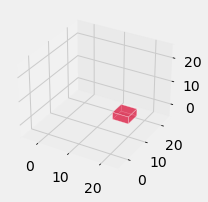

In [70]:
vis_box([box], [pos])

In [71]:
w_upleft = whole_upleft(*box_cornel([0,0],20,20),box[0],box[1])
f_upleft = feasible_location(history, w_upleft, box[0],box[1],box[2],
                            state_H = env.height, is2d=False)
f_upleft

array([[ 0,  0],
       [ 0, 15],
       [15,  0],
       [15, 15]])

In [72]:
history.shape

(20, 20)

In [73]:
history = history.flatten()
history.shape

(400,)

In [74]:
history = np.reshape(history, [1, state_size])
history.shape

(1, 400)

In [75]:
policy = actor.predict(history, batch_size=1)
policy

array([[0.25, 0.25, 0.25, 0.25]], dtype=float32)

In [76]:
policy = policy.flatten()
policy

array([0.25, 0.25, 0.25, 0.25], dtype=float32)

In [77]:
action = np.random.choice(action_size, 1, p=policy)
#action = np.random.choice(2, 1, p=policy[:2])
action

array([0])

In [78]:
action = action[0]
action

0

In [79]:
box_list.append(box)
pos_list.append(f_upleft[action])

In [80]:
next_state, reward = env.step(f_upleft[action], box[0], box[1], box[2])
next_state, reward

(array([[3., 3., 3., 3., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [3., 3., 3., 3., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [3., 3., 3., 3., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [3., 3., 3., 3., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [3., 3., 3., 3., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0

In [81]:
next_state = np.reshape(next_state, [1, state_size])
next_state.shape

(1, 400)

In [82]:
target = np.zeros((1,1))
advantages = np.zeros((1,action_size))
target, advantages

(array([[0.]]), array([[0., 0., 0., 0.]]))

In [83]:
value = critic.predict(history)
value

array([[0.]], dtype=float32)

In [84]:
next_value = critic.predict(next_state)
next_value

array([[-0.1372577]], dtype=float32)

In [85]:
value = value[0]
next_value = next_value[0]
value, next_value

(array([0.], dtype=float32), array([-0.1372577], dtype=float32))

In [86]:
advantages[0][action] = reward + 0.99 * (next_value)-value
target[0][0] = reward + 0.99 * next_value
target, advantages

(array([[-0.12651011]]),
 array([[-0.12651011,  0.        ,  0.        ,  0.        ]]))

In [87]:
advantages[0]

array([-0.12651011,  0.        ,  0.        ,  0.        ])

In [88]:
actor_history = actor.fit(history, advantages, epochs=1)
actor_history

1/1 [==============================] - 0s 277ms/step - loss: -0.1754


In [89]:
critic_history = critic.fit(history, target, epochs = 1)
critic_history

1/1 [==============================] - 0s 327ms/step - loss: 0.0160


In [94]:
box_list[0], np.array([pos_list[0][0], pos_list[0][1], 0])

(array([5, 5, 3]), array([0, 0, 0]))

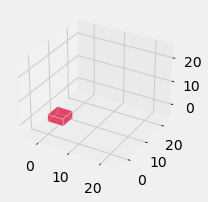

In [95]:
vis_box([box_list[0]], [np.array([pos_list[0][0], pos_list[0][1], 0])])

In [96]:
step += 1
box = boxes[step]

In [99]:
box

array([ 5, 20,  3])

In [102]:
history = env.container.copy()
history

array([[3., 3., 3., 3., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [3., 3., 3., 3., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [3., 3., 3., 3., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [3., 3., 3., 3., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [3., 3., 3., 3., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.

In [103]:
w_upleft = whole_upleft(*box_cornel([0,0],20,20),box[0],box[1])
f_upleft = feasible_location(history, w_upleft, box[0],box[1],box[2],
                            state_H = env.height, is2d=False)
f_upleft

array([[15,  0]])

In [104]:
history = np.reshape(history, [1,state_size])
history.shape

(1, 400)

In [105]:
policy = actor.predict(history, batch_size=1)
policy

array([[0.17244901, 0.59580594, 0.03457236, 0.19717264]], dtype=float32)

In [106]:
policy = policy.flatten()
policy

array([0.17244901, 0.59580594, 0.03457236, 0.19717264], dtype=float32)

In [114]:
this_action_size = 1
policy = policy[:this_action_size]
policy

array([0.17244901], dtype=float32)

In [152]:
p_list = []
for p in policy:
    p_list.append(round(p,2))
p_list = np.array(p_list)
p_list

array([0.17], dtype=float32)

In [153]:
m = 1 / sum(p_list)
m = round(m, 2)
m

5.88

In [154]:
for i in range(len(p_list)):
    p_list[i] = round(p_list[i] * m, 2)
p_list

array([1.], dtype=float32)

In [155]:
sum(p_list)

1.0

In [124]:
action = np.random.choice(this_action_size, 1, p=p_list)
action

array([0])

In [125]:
action = action[0]
action

0

In [126]:
box_list.append(box)
pos_list.append(f_upleft[action])

In [127]:
next_state, reward = env.step(f_upleft[action], box[0], box[1], box[2])
next_state, reward

(array([[3., 3., 3., 3., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [3., 3., 3., 3., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [3., 3., 3., 3., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [3., 3., 3., 3., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [3., 3., 3., 3., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0

In [128]:
next_state = np.reshape(next_state, [1, state_size])

In [136]:
target = np.zeros((1, 1))
advantages = np.zeros((1, action_size))
target, advantages

(array([[0.]]), array([[0., 0., 0., 0.]]))

In [130]:
value = critic.predict(history)[0]
next_value = critic.predict(next_state)[0]
value, next_value

(array([-0.14225778], dtype=float32), array([-1.1788225], dtype=float32))

In [137]:
advantages[0][action] = reward + 0.99 * (next_value) - value
target[0][0] = reward + 0.99 * next_value
advantages, target

(array([[-0.97790146,  0.        ,  0.        ,  0.        ]]),
 array([[-1.12015927]]))

In [138]:
history.shape, advantages.shape

((1, 400), (1, 4))

In [139]:
actor.fit(history, advantages, epochs=1)

1/1 [==============================] - 0s 5ms/step - loss: -1.7188


In [140]:
critic.fit(history, target, epochs=1)

1/1 [==============================] - 0s 5ms/step - loss: 0.9563


In [142]:
box_list, pos_list

([array([5, 5, 3]), array([ 5, 20,  3])], [array([0, 0]), array([15,  0])])

In [144]:
p_list = []
for pos in pos_list:
    p_list.append(np.array([pos[0], pos[1], 0]))
p_list

[array([0, 0, 0]), array([15,  0,  0])]

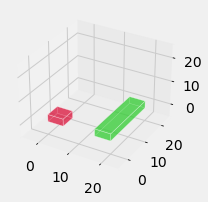

In [145]:
vis_box(box_list, p_list)

In [147]:
step += 1
box = boxes[step]

In [149]:
history = env.container.copy()
box

array([5, 5, 3])

In [150]:
history

array([[3., 3., 3., 3., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [3., 3., 3., 3., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [3., 3., 3., 3., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [3., 3., 3., 3., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [3., 3., 3., 3., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.

In [151]:
w_upleft = whole_upleft(*box_cornel([0,0],20,20),box[0],box[1])
f_upleft = feasible_location(history, w_upleft, box[0],box[1],box[2],
                            state_H = env.height, is2d=False)
f_upleft

array([[ 0,  0],
       [ 0, 15],
       [15,  0],
       [15, 15]])

In [156]:
history = np.reshape(history, [1, state_size])
history.shape

(1, 400)

In [157]:
policy = actor.predict(history, batch_size = 1)
policy

array([[0.1717689 , 0.07421978, 0.00298312, 0.7510282 ]], dtype=float32)

In [158]:
policy = policy.flatten()
policy

array([0.1717689 , 0.07421978, 0.00298312, 0.7510282 ], dtype=float32)

In [159]:
action = np.random.choice(action_size, 1, p=policy)[0]
action

3

In [160]:
box_list.append(box)
pos_list.append(f_upleft[action])

In [166]:
box_list

[array([5, 5, 3]), array([ 5, 20,  3]), array([5, 5, 3])]

In [161]:
next_state, reward = env.step(f_upleft[action], box[0], box[1], box[2])
next_state, reward

(array([[3., 3., 3., 3., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [3., 3., 3., 3., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [3., 3., 3., 3., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [3., 3., 3., 3., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [3., 3., 3., 3., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0

In [162]:
h = 3

In [163]:
next_state = np.reshape(next_state, [1,state_size])

In [164]:
target = np.zeros((1,1))
advantages = np.zeros((1,action_size))
target, advantages

(array([[0.]]), array([[0., 0., 0., 0.]]))

In [165]:
value = critic.predict(history)[0]
next_value = critic.predict(next_state)[0]
value, next_value

(array([-1.5815783], dtype=float32), array([-1.8459578], dtype=float32))

In [167]:
advantages[0][action] = reward + 0.99 * (next_value) - value
target[0][0] = reward + 0.99 * next_value
advantages, target

(array([[ 0.        ,  0.        ,  0.        , -0.18966997]]),
 array([[-1.77124822]]))

In [168]:
actor.fit(history, advantages, epochs=1)

1/1 [==============================] - 0s 5ms/step - loss: -0.0543


In [169]:
critic.fit(history, advantages, epochs = 1)

1/1 [==============================] - 0s 167ms/step - loss: 2.3604


In [170]:
p_list = []
h_list = [0,0,3]
for pos, h in zip(pos_list, h_list):
    p_list.append(np.array([pos[0], pos[1], h]))
p_list

[array([0, 0, 0]), array([15,  0,  0]), array([15, 15,  3])]

In [182]:
def cuboid_data2(o, size=(1,1,1)):
    X = [[[0, 1, 0], [0, 0, 0], [1, 0, 0], [1, 1, 0]],
         [[0, 0, 0], [0, 0, 1], [1, 0, 1], [1, 0, 0]],
         [[1, 0, 1], [1, 0, 0], [1, 1, 0], [1, 1, 1]],
         [[0, 0, 1], [0, 0, 0], [0, 1, 0], [0, 1, 1]],
         [[0, 1, 0], [0, 1, 1], [1, 1, 1], [1, 1, 0]],
         [[0, 1, 1], [0, 0, 1], [1, 0, 1], [1, 1, 1]]]
    X = np.array(X).astype(float)
    for i in range(3):
        X[:,:,i] *= size[i]
    X += np.array(o)
    return X

def plotCubeAt2(positions,sizes=None,colors=None, **kwargs):
    if not isinstance(colors,(list,np.ndarray)): colors=["C0"]*len(positions)
    if not isinstance(sizes,(list,np.ndarray)): sizes=[(1,1,1)]*len(positions)
    g = []
    for p,s,c in zip(positions,sizes,colors):
        g.append( cuboid_data2(p, size=s) )
    return Poly3DCollection(np.concatenate(g),facecolors=np.repeat(colors,6), alpha=0.5, **kwargs)

def get_colors(n_box):
    color_names=["crimson","limegreen","grey","brown","orange","olive","blue","purple","yellow","pink","skyblue","red","aqua","gold"]
    colors = color_names*(n_box//len(color_names))+color_names[:n_box%len(color_names)]
    return colors

def vis_box(sizes,positions,fs=(3,3)):
    colors = get_colors(len(positions))
    fig = plt.figure(figsize=fs)
    ax = fig.gca(projection='3d')
    ax.set_aspect('auto')
    pc = plotCubeAt2(positions,sizes,colors=colors, edgecolor="w")
    ax.add_collection3d(pc)    
    ax.set_xlim([-5,25])
    ax.set_ylim([-5,25])
    ax.set_zlim([-5,25])
    return ax

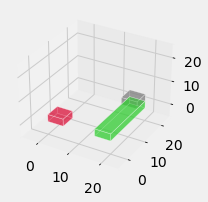

<Axes3DSubplot:>

In [177]:
vis_box(box_list, p_list)

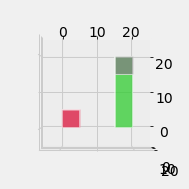

In [183]:
ax = vis_box(box_list, p_list)
ax.view_init(90,-90)

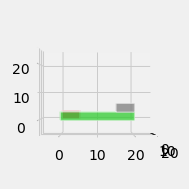

In [184]:
ax = vis_box(box_list, p_list)
ax.view_init(0,0)

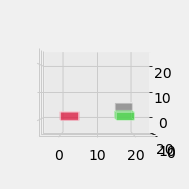

In [185]:
ax = vis_box(box_list, p_list)
ax.view_init(0,-90)

In [167]:
import gym
env = gym.make('CartPole-v0')
env.action_space.n, env.observation_space.shape[0]

(2, 4)

In [168]:
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

actor = build_actor(state_size, action_size)
critic = build_critic(state_size)

state = env.reset()
state, state.shape

(array([0.03099091, 0.00212498, 0.00502325, 0.01542857]), (4,))

In [169]:
state = np.reshape(state, [1,state_size])
state, state.shape

(array([[0.03099091, 0.00212498, 0.00502325, 0.01542857]]), (1, 4))

In [170]:
policy = actor.predict(state, batch_size=1)
policy

array([[0.49973077, 0.50026923]], dtype=float32)

In [171]:
policy = policy.flatten()
policy

array([0.49973077, 0.50026923], dtype=float32)

In [172]:
action = np.random.choice(action_size, 1, p=policy)
action

array([1])

In [173]:
action = action[0]
action

1

In [174]:
next_state, reawrd, done, _ = env.step(action)
next_state, reward

(array([ 0.03103341,  0.19717453,  0.00533182, -0.27566523]), 0.0075)

In [175]:
next_state.shape

(4,)

In [176]:
next_state = np.reshape(next_state, [1,state_size])
next_state, next_state.shape

(array([[ 0.03103341,  0.19717453,  0.00533182, -0.27566523]]), (1, 4))

In [177]:
target = np.zeros((1,1))
advantages = np.zeros((1, action_size))
target, advantages

(array([[0.]]), array([[0., 0.]]))

In [178]:
value = critic.predict(state)
value

array([[0.00828244]], dtype=float32)

In [179]:
next_value = critic.predict(next_state)
next_value

array([[0.13211402]], dtype=float32)

In [180]:
value = value[0]
next_value = next_value[0]
value, next_value

(array([0.00828244], dtype=float32), array([0.13211402], dtype=float32))

In [181]:
advantages[0][action] = reward + 0.99 * (next_value) - value
advantages

array([[0.        , 0.13001044]])

In [182]:
target[0][0] = reward + 0.99 * next_value
target

array([[0.13829288]])

In [183]:
state.shape, advantages.shape

((1, 4), (1, 2))

In [185]:
history = actor.fit(state, advantages, epochs=1)

1/1 [==============================] - 0s 392ms/step - loss: 0.0900


In [187]:
history.history['loss']

[0.09004638344049454]

In [188]:
state.shape, target.shape

((1, 4), (1, 1))

In [189]:
history_c = critic.fit(state, target, epochs=1)

1/1 [==============================] - 0s 280ms/step - loss: 0.0169


In [190]:
history_c.history['loss']

[0.01690271496772766]

In [192]:
state = next_state
state, state.shape

(array([[ 0.03103341,  0.19717453,  0.00533182, -0.27566523]]), (1, 4))

In [193]:
policy = actor.predict(state, batch_size=1)
policy

array([[0.5366455 , 0.46335456]], dtype=float32)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 24)                120       
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 50        
Total params: 170
Trainable params: 170
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 24)                120       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 25        
Total params: 145
Trainable params: 145
Non-trainable params: 0
_________________________________________________________________
episode: 0   score: 57.0
episode: 1 

KeyboardInterrupt: 

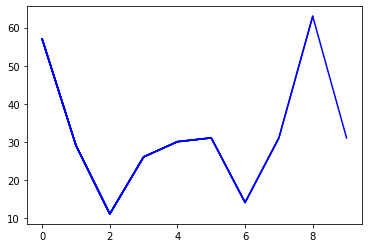

In [2]:
import sys
import gym
import pylab
import numpy as np
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

EPISODES = 100


# A2C(Advantage Actor-Critic) agent for the Cartpole
class A2CAgent:
    def __init__(self, state_size, action_size):
        # if you want to see Cartpole learning, then change to True
        self.render = False
        self.load_model = False
        # get size of state and action
        self.state_size = state_size
        self.action_size = action_size
        self.value_size = 1

        # These are hyper parameters for the Policy Gradient
        self.discount_factor = 0.99
        self.actor_lr = 0.001
        self.critic_lr = 0.005

        # create model for policy network
        self.actor = self.build_actor()
        self.critic = self.build_critic()

        if self.load_model:
            self.actor.load_weights("./save_model/cartpole_actor.h5")
            self.critic.load_weights("./save_model/cartpole_critic.h5")

    # approximate policy and value using Neural Network
    # actor: state is input and probability of each action is output of model
    def build_actor(self):
        actor = Sequential()
        actor.add(Dense(24, input_dim=self.state_size, activation='relu',
                        kernel_initializer='he_uniform'))
        actor.add(Dense(self.action_size, activation='softmax',
                        kernel_initializer='he_uniform'))
        actor.summary()
        # See note regarding crossentropy in cartpole_reinforce.py
        actor.compile(loss='categorical_crossentropy',
                      optimizer=Adam(lr=self.actor_lr))
        return actor

    # critic: state is input and value of state is output of model
    def build_critic(self):
        critic = Sequential()
        critic.add(Dense(24, input_dim=self.state_size, activation='relu',
                         kernel_initializer='he_uniform'))
        critic.add(Dense(self.value_size, activation='linear',
                         kernel_initializer='he_uniform'))
        critic.summary()
        critic.compile(loss="mse", optimizer=Adam(lr=self.critic_lr))
        return critic

    # using the output of policy network, pick action stochastically
    def get_action(self, state):
        policy = self.actor.predict(state, batch_size=1).flatten()
        return np.random.choice(self.action_size, 1, p=policy)[0]

    # update policy network every episode
    def train_model(self, state, action, reward, next_state, done):
        target = np.zeros((1, self.value_size))
        advantages = np.zeros((1, self.action_size))

        value = self.critic.predict(state)[0]
        next_value = self.critic.predict(next_state)[0]

        if done:
            advantages[0][action] = reward - value
            target[0][0] = reward
        else:
            advantages[0][action] = reward + self.discount_factor * (next_value) - value
            target[0][0] = reward + self.discount_factor * next_value

        self.actor.fit(state, advantages, epochs=1, verbose=0)
        self.critic.fit(state, target, epochs=1, verbose=0)


if __name__ == "__main__":
    # In case of CartPole-v1, maximum length of episode is 500
    env = gym.make('CartPole-v1')
    # get size of state and action from environment
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    # make A2C agent
    agent = A2CAgent(state_size, action_size)

    scores, episodes = [], []

    for e in range(EPISODES):
        done = False
        score = 0
        state = env.reset()
        state = np.reshape(state, [1, state_size])
        step = 0

        while not done:
            if agent.render:
                env.render()

            action = agent.get_action(state)
            next_state, reward, done, info = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])
            # if an action make the episode end, then gives penalty of -100
            reward = reward if not done or score == 499 else -100
            
            agent.train_model(state, action, reward, next_state, done)

            score += reward
            state = next_state
            step += 1

            if done:
                # every episode, plot the play time
                score = score if score == 500.0 else score + 100
                scores.append(score)
                episodes.append(e)
                pylab.plot(episodes, scores, 'b')
                pylab.savefig("cartpole_a2c.png")
                print("episode:", e, "  score:", score)

                # if the mean of scores of last 10 episode is bigger than 490
                # stop training
                if np.mean(scores[-min(10, len(scores)):]) > 490:
                    sys.exit()